In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
import pde
from pde import GenerateData, NeuralNet, LinearQuadraticRegulator2D, NonLinear
from tqdm import tqdm
import spdlayers

In [88]:
layers = [2, 20, 3]
network = NeuralNet(layers=layers, quadraticForm=False, imposePsd=False, imposeCholesky=False, spd=True, **{'countMatrices': 1})
gamma = {'matrix':0, 'residual':1, 'data':0, 'gradient':0}
lqr = NonLinear(network=network, gamma=gamma, correctShift=False)

lrs = [1e-1, 1e-2]
iterations = [1000, 2000]

In [89]:
resu = lqr.train(
    interiorPointCount=100,
    dataPointCount=100,
    lrs=lrs,
    iterations=iterations,
    useTestData=False,
    verbose=True
    )

xInt:  torch.Size([100, 2])
xData:  torch.Size([100, 2])


In [ ]:
fig, ax = plt.subplots()
resu['loss'].plot(ax=ax, color='blue')
resu['mse'].plot(ax=ax, color='black')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Iterations')
ax.set_ylabel('Error');

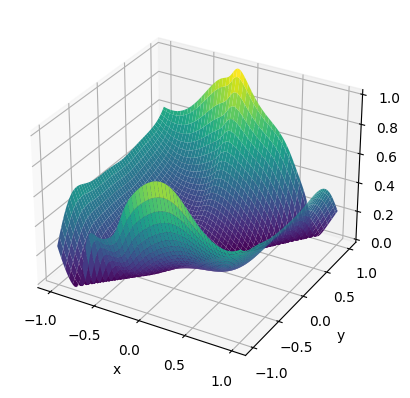

In [90]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = lqr.getEvaluationPoints()

Z = network.computeValueFunction(space).reshape(-1, 100)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');
ax.set_xlabel('x')
ax.set_ylabel('y');

# Impose positive definite matrix P
- using Singular Value Decomposition
- using Cholesky

In [19]:
P = np.array([[np.sqrt(3), 1], [1, np.sqrt(3)]])
P

array([[1.73205081, 1.        ],
       [1.        , 1.73205081]])

In [20]:
# in this case we predict L
L = np.linalg.cholesky(P)
L @ L.T

array([[1.73205081, 1.        ],
       [1.        , 1.73205081]])

In [21]:
# in this case we generate a random orthogonal matrix Q and we predict the diagonal matrix
u, s, vh = np.linalg.svd(P)
u @ np.diag(s) @ vh

array([[1.73205081, 1.        ],
       [1.        , 1.73205081]])

In [22]:
Q = ortho_group.rvs(2)
Q

array([[-0.02523941, -0.99968144],
       [ 0.99968144, -0.02523941]])

# Linear example

In [23]:
layers = [2, 20, 2]
network = NeuralNet(layers=layers, quadraticForm=False, useAdditionalModel=False, imposePsd=True, imposeCholesky=False, **{'countMatrices': 1})
gamma = {'matrix':0, 'residual':1, 'data':0, 'gradient':0}
lqr = LinearQuadraticRegulator2D(network=network, gamma=gamma, correctShift=False)

lrs = [1e-2, 1e-3]
iterations = [1000, 2000]

In [24]:
resu = lqr.train(
    interiorPointCount=100,
    dataPointCount=1,
    lrs=lrs,
    iterations=iterations,
    useTestData=False,
    verbose=True
    )

xInt:  torch.Size([100, 2])
xData:  torch.Size([1, 2])
0 / 3000 (0 / 1000), lr:1.0e-02, loss:1.18e-01 (data: 0.00e+00, grad: 0.00e+00, res: 1.18e-01, mat: 0.00e+00)
100 / 3000 (100 / 1000), lr:1.0e-02, loss:2.76e-05 (data: 0.00e+00, grad: 0.00e+00, res: 2.76e-05, mat: 0.00e+00)
200 / 3000 (200 / 1000), lr:1.0e-02, loss:1.92e-05 (data: 0.00e+00, grad: 0.00e+00, res: 1.92e-05, mat: 0.00e+00)
300 / 3000 (300 / 1000), lr:1.0e-02, loss:1.51e-05 (data: 0.00e+00, grad: 0.00e+00, res: 1.51e-05, mat: 0.00e+00)
400 / 3000 (400 / 1000), lr:1.0e-02, loss:1.16e-05 (data: 0.00e+00, grad: 0.00e+00, res: 1.16e-05, mat: 0.00e+00)
500 / 3000 (500 / 1000), lr:1.0e-02, loss:8.83e-06 (data: 0.00e+00, grad: 0.00e+00, res: 8.83e-06, mat: 0.00e+00)
600 / 3000 (600 / 1000), lr:1.0e-02, loss:6.68e-06 (data: 0.00e+00, grad: 0.00e+00, res: 6.68e-06, mat: 0.00e+00)
700 / 3000 (700 / 1000), lr:1.0e-02, loss:5.09e-06 (data: 0.00e+00, grad: 0.00e+00, res: 5.09e-06, mat: 0.00e+00)
800 / 3000 (800 / 1000), lr:1.0e-02, 

KeyboardInterrupt: 

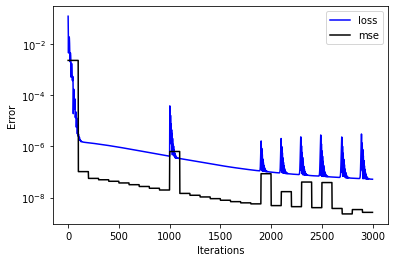

In [ ]:
fig, ax = plt.subplots()
resu['loss'].plot(ax=ax, color='blue')
resu['mse'].plot(ax=ax, color='black')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Iterations')
ax.set_ylabel('Error');

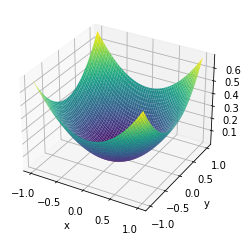

In [ ]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = lqr.getEvaluationPoints()

Z = network.computeValueFunction(space).reshape(-1, 100)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');
ax.set_xlabel('x')
ax.set_ylabel('y');

## Non linear example

In [ ]:
layers = [2, 20, 6]
network = NeuralNet(layers=layers, quadraticForm=False, useAdditionalModel=False, imposePsd=True, imposeCholesky=False, **{'countMatrices': 3})
gamma = {'matrix':0, 'residual':1, 'data':0, 'gradient':0}
pde = NonLinear(network=network, gamma=gamma, correctShift=False, eps=1)

lrs = [1e-2, 1e-3]
iterations = [1000, 4000]

In [ ]:
resu = pde.train(
    interiorPointCount=100,
    dataPointCount=1,
    lrs=lrs,
    iterations=iterations,
    useTestData=False,
    verbose=True
    )

xInt:  torch.Size([100, 2])
xData:  torch.Size([1, 2])
0 / 5000 (0 / 1000), lr:1.0e-02, loss:6.41e-01 (data: 0.00e+00, grad: 0.00e+00, res: 6.41e-01, mat: 0.00e+00)
100 / 5000 (100 / 1000), lr:1.0e-02, loss:7.00e-02 (data: 0.00e+00, grad: 0.00e+00, res: 7.00e-02, mat: 0.00e+00)
200 / 5000 (200 / 1000), lr:1.0e-02, loss:6.84e-02 (data: 0.00e+00, grad: 0.00e+00, res: 6.84e-02, mat: 0.00e+00)
300 / 5000 (300 / 1000), lr:1.0e-02, loss:6.78e-02 (data: 0.00e+00, grad: 0.00e+00, res: 6.78e-02, mat: 0.00e+00)
400 / 5000 (400 / 1000), lr:1.0e-02, loss:6.75e-02 (data: 0.00e+00, grad: 0.00e+00, res: 6.75e-02, mat: 0.00e+00)
500 / 5000 (500 / 1000), lr:1.0e-02, loss:6.71e-02 (data: 0.00e+00, grad: 0.00e+00, res: 6.71e-02, mat: 0.00e+00)
600 / 5000 (600 / 1000), lr:1.0e-02, loss:6.65e-02 (data: 0.00e+00, grad: 0.00e+00, res: 6.65e-02, mat: 0.00e+00)
700 / 5000 (700 / 1000), lr:1.0e-02, loss:6.53e-02 (data: 0.00e+00, grad: 0.00e+00, res: 6.53e-02, mat: 0.00e+00)
800 / 5000 (800 / 1000), lr:1.0e-02, 

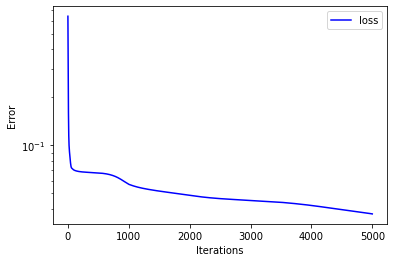

In [ ]:
fig, ax = plt.subplots()
resu['loss'].plot(ax=ax, color='blue')
#resu['mse'].plot(ax=ax, color='black')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Iterations')
ax.set_ylabel('Error');

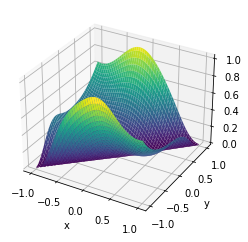

In [ ]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints()

Z = network.computeValueFunction(space).reshape(-1, 100)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');
ax.set_xlabel('x')
ax.set_ylabel('y');

## Multiple runs

In [ ]:
import ray

/usr/local/lib/python3.9/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


In [ ]:
ray.shutdown()
ray.init()

2022-09-04 17:39:26,879	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.0.10',
 'raylet_ip_address': '192.168.0.10',
 'redis_address': '192.168.0.10:6379',
 'object_store_address': '/tmp/ray/session_2022-09-04_17-39-25_372835_17879/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-09-04_17-39-25_372835_17879/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2022-09-04_17-39-25_372835_17879',
 'metrics_export_port': 61321,
 'node_id': '45164a8028cc241629e34d1fc5a53f4947f9d51e4938b21bb5471bb1'}

In [ ]:
@ray.remote
def computeExperiments(lr):
    layers = [2, 20, 3]
    network = NeuralNet(layers=layers, quadraticForm=False, useAdditionalModel=False, imposePsd=False, imposeCholesky=True, **{'countMatrices': 1})
    gamma = {'matrix':0, 'residual':1, 'data':0, 'gradient':0}
    pde = NonLinear(network=network, gamma=gamma, correctShift=False, eps=1)

    lrs = [lr, 0.1*lr]
    iterations = [1000, 4000]

    resu = pde.train(
        interiorPointCount=100,
        dataPointCount=1,
        lrs=lrs,
        iterations=iterations,
        useTestData=False,
        verbose=False
        )

    info_dict = {}
    info_dict['lr'] = lr
    info_dict['loss'] = resu['loss'].iloc[-1]
    info_dict['mse'] = resu['mse'].iloc[-1]

    space = pde.getEvaluationPoints()
    Z = network.computeValueFunction(space).reshape(-1, 100)
    info_dict['Z'] =  Z
    info_dict['resu'] = resu
    return info_dict

In [ ]:
inputs = [1e-1, 1e-2, 1e-3] * 50

In [ ]:
refs = []
for lr in inputs:
    refs.append(computeExperiments.remote(lr))

returns = ray.get(refs)
returns = pd.DataFrame( returns )

(pid=81518) xInt:  torch.Size([100, 2])
(pid=81518) xData:  torch.Size([1, 2])
(pid=81516) xInt:  torch.Size([100, 2])
(pid=81516) xData:  torch.Size([1, 2])
(pid=81521) xInt:  torch.Size([100, 2])
(pid=81521) xData:  torch.Size([1, 2])
(pid=81515) xInt:  torch.Size([100, 2])
(pid=81515) xData:  torch.Size([1, 2])
(pid=81513) xInt:  torch.Size([100, 2])
(pid=81513) xData:  torch.Size([1, 2])
(pid=81517) xInt:  torch.Size([100, 2])
(pid=81517) xData:  torch.Size([1, 2])
(pid=81519) xInt:  torch.Size([100, 2])
(pid=81519) xData:  torch.Size([1, 2])
(pid=81522) xInt:  torch.Size([100, 2])
(pid=81522) xData:  torch.Size([1, 2])
(pid=81520) xInt:  torch.Size([100, 2])
(pid=81520) xData:  torch.Size([1, 2])
(pid=81514) xInt:  torch.Size([100, 2])
(pid=81514) xData:  torch.Size([1, 2])
(pid=81518) xInt:  torch.Size([100, 2])
(pid=81518) xData:  torch.Size([1, 2])
(pid=81521) xInt:  torch.Size([100, 2])
(pid=81521) xData:  torch.Size([1, 2])
(pid=81515) xInt:  torch.Size([100, 2])
(pid=81515) 

In [ ]:
returns[['lr', 'mse', 'loss']].sort_values('mse').iloc[:10]

,lr,mse,loss
112,0.010,0.000247,0.000235
131,0.001,0.000320,0.000392
1,0.010,0.000530,0.000259
142,0.010,0.001869,0.000456
86,0.001,0.007584,0.004671
128,0.001,0.009843,0.002959
74,0.001,0.025041,0.008985
113,0.001,0.036605,0.047616
29,0.001,0.063540,0.029713
103,0.010,0.305382,0.003260


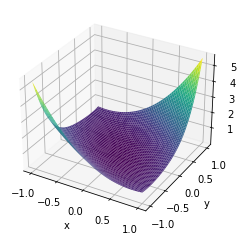

In [ ]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints()

Z = returns.iloc[1]['Z']

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');
ax.set_xlabel('x')
ax.set_ylabel('y');

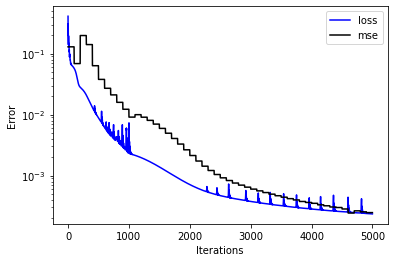

In [ ]:
fig, ax = plt.subplots()
returns[ returns['mse'] == returns['mse'].min() ]['resu'].item()['loss'].plot(ax=ax, color='blue')
returns[ returns['mse'] == returns['mse'].min() ]['resu'].item()['mse'].plot(ax=ax, color='black')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Iterations')
ax.set_ylabel('Error');

lr: 1.0e-02


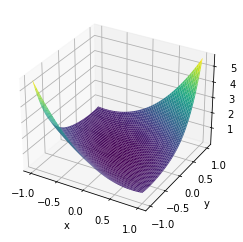

: 

In [ ]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints()

Z = returns[ returns['mse'] == returns['mse'].min() ]['Z'].item()
print('lr: %.1e' % returns[ returns['mse'] == returns['mse'].min() ]['lr'])

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');
ax.set_xlabel('x')
ax.set_ylabel('y');

## Two step learning

In [ ]:
# network creation
layers = [2, 20, 3]
network = NeuralNet(layers=layers, quadraticForm=True, useAdditionalModel=False, imposePsd=False)

# pde creation
gamma = {'matrix':0, 'residual':0, 'data':1, 'gradient':0}
pde = NonLinear(network=network, gamma=gamma, correctShift=False, eps=0)

# training data
resu_data = pde.train(
    interiorPointCount=1,
    dataPointCount=20,
    lrs=[1e-2, 1e-3],
    iterations=[1000, 2000]
)

saved_weights = copy.deepcopy( pde.network.state_dict() )

xInt:  torch.Size([1, 2])
xData:  torch.Size([20, 2])


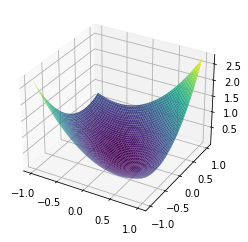

In [ ]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints()

Z = pde.network.computeValueFunction(space).reshape(-1, 100)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

In [ ]:
# second training
gamma_residual = {'matrix':0, 'residual':1, 'data':0, 'gradient':0}
pde = NonLinear(network=network, gamma=gamma_residual, correctShift=False, eps=0)

pde.network.load_state_dict( saved_weights )

<All keys matched successfully>

In [ ]:
resu_residual = pde.train(
    interiorPointCount=1000,
    dataPointCount=1,
    lrs=[1e-2, 1e-3],
    iterations=[2000, 5000]
)

xInt:  torch.Size([1000, 2])
xData:  torch.Size([1, 2])


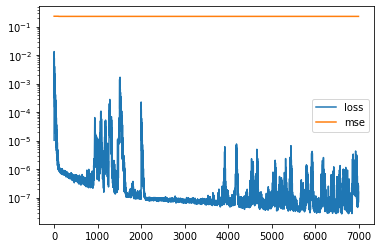

In [ ]:
fig, ax = plt.subplots()
resu_residual['loss'].plot(ax=ax)
resu_residual['mse'].plot(ax=ax)
ax.set_yscale('log')
ax.legend();

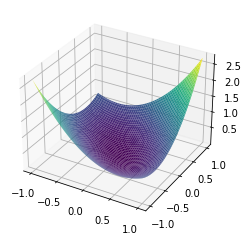

In [ ]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints()

Z = pde.network.computeValueFunction(space).reshape(-1, 100)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

## Debug

In [ ]:
dim = space.shape[1]
stackedMatrices = torch.zeros((space.shape[0], dim, dim))
outputModel = network.model(space)

inds = np.triu_indices( dim )
k = 0
for i, j in zip( inds[0], inds[1] ):
    stackedMatrices[:, i, j] = outputModel[:, k]
    stackedMatrices[:, j, i] = outputModel[:, k]
    k += 1

In [ ]:
stackedMatrices.var(axis=0)

tensor([[0.0003, 0.0028],
        [0.0028, 0.0111]], grad_fn=<VarBackward1>)

In [ ]:
dim = space.shape[1]

# the below is SUPER fast
stackedMatrices = torch.zeros((space.shape[0], dim, dim))
outputModel = network.model(space)
#outputModel = torch.exp(outputModel)

for i in range( dim ):
    stackedMatrices[:, i, i] = outputModel[:, i]

stackedMatricesPsd = network.orthogonalMatrix @ stackedMatrices @ network.orthogonalMatrix.T